In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import specgram
import time
from sklearn.cross_validation import train_test_split
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
def load_sounds(parent_dir,sub_dirs,file_ext="*.wav"):
    namePath = []
    sounds = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            sound_clip,sr = librosa.load(fn)
            sounds.append(sound_clip)
            
            namePath.append(fn)
            
            label = fn.split('/')[-1].split('-')[1]
            labels.append(label)
    sounds_ID = np.arange(np.shape(sounds)[0])
    sounds = np.array(sounds)
    labels = np.array(labels,dtype = np.int)
    namePath = np.array(namePath, dtype=np.string_)
    train_x, test_x, train_y, test_y = train_test_split(sounds_ID, labels, test_size=0.3, random_state=4, stratify=labels)
    
    return sounds[train_x], train_y, namePath[train_x], sounds[test_x], test_y, namePath[test_y]

In [24]:
# # Only for the first time running
# parent_dir = '../../data/UrbanSound8K/audio/'
# sub_dirs= ['fold1','fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8','fold9', 'fold10']
# # sub_dirs= ['fold1']
# print "---Loading Sounds.... ---"
# start_time = time.time()
# train_x , train_y, train_name, test_x, test_y, test_name = load_sounds(parent_dir,sub_dirs)
# print "---Loading time: {0} seconds ---".format(time.time() - start_time)

---Loading Sounds.... ---
---Loading time: 1891.92376804 seconds ---


In [43]:
# # All Folds
# np.save("cnn_train_features_full", train_x, allow_pickle=True)
# np.save("cnn_train_labels_full", train_y, allow_pickle=True)
# np.save("cnn_train_file_names_full", train_name, allow_pickle=True)

In [44]:
# # All Folds
# np.save("cnn_test_features_full", test_x, allow_pickle=True)
# np.save("cnn_test_labels_full", test_y, allow_pickle=True)
# np.save("cnn_test_file_names_full", test_name, allow_pickle=True)

In [4]:
# All Folds
train_x = np.load("cnn_train_features_full.npy", allow_pickle=True)
train_y = np.load("cnn_train_labels_full.npy", allow_pickle=True)
train_files = np.load("cnn_train_file_names_full.npy", allow_pickle=True)

In [5]:
# All Folds
test_x = np.load("cnn_test_features_full.npy", allow_pickle=True)
test_y = np.load("cnn_test_labels_full.npy", allow_pickle=True)
test_files = np.load("cnn_test_file_names_full.npy", allow_pickle=True)

In [9]:
sr = 22050
N_TRAIN_FOLDS = 10
def extract_train_features(data, labels, names,  bands = 128, frames = 128):
    data_length = np.shape(data)[0]
    n_patches = np.int32(np.floor(data_length/(N_TRAIN_FOLDS-1)))
    for fold in np.arange(N_TRAIN_FOLDS):
        fold_start = fold*n_patches
        log_specgrams = []
        sound_name = []
        sound_labels = []
        for idx in np.arange(fold_start, fold_start+n_patches):
            if(idx >= data_length):
                break;
            melspec = librosa.feature.melspectrogram(data[idx], sr=sr, n_fft=512, hop_length=512)
            n_frames = np.shape(melspec)[1]
            if(n_frames >= frames):
                start = np.random.randint(n_frames-frames+1)
                melspec = melspec[:,start:start+frames]

                logspec = librosa.logamplitude(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                sound_name.append(names[idx])
                sound_labels.append(labels[idx])    
        features = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
        # All Folds
        np.save("train_data/cnn_train_features_full_fold_"+str(fold+1), np.array(features), allow_pickle=True)
        np.save("train_data/cnn_train_labels_full_fold_"+str(fold+1), np.array(sound_labels,dtype = np.int), allow_pickle=True)
        np.save("train_data/cnn_train_file_names_full_fold_"+str(fold+1), np.array(sound_name,dtype = np.str_), allow_pickle=True)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [10]:
extract_train_features(train_x, train_y, train_files)

In [11]:
def load_train_data():
    train_features = np.load("train_data/cnn_train_features_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TRAIN_FOLDS):
        train_fold = np.load("train_data/cnn_train_features_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        train_features = np.concatenate([train_features, train_fold], axis=0)
    
    train_labels = np.load("train_data/cnn_train_labels_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TRAIN_FOLDS):
        train_fold = np.load("train_data/cnn_train_labels_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        train_labels = np.concatenate([train_labels, train_fold], axis=0)
    
    train_names = np.load("train_data/cnn_train_file_names_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TRAIN_FOLDS):
        train_fold = np.load("train_data/cnn_train_file_names_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        train_names = np.concatenate([train_names, train_fold], axis=0)
    return train_features, train_labels, train_names

In [12]:
train_features, train_labels, train_names = load_train_data()

In [13]:
sr = 22050
N_TEST_FOLDS = 20
def extract_test_features(data, labels, names,  bands = 128, frames = 128):
    data_length = np.shape(data)[0]
    n_patches = np.int32(np.floor(data_length/(N_TEST_FOLDS-1)))
    for fold in np.arange(N_TEST_FOLDS):
        fold_start = fold*n_patches
        log_specgrams = []
        sound_name = []
        sound_labels = []
        sound_IDs = []
        for idx in np.arange(fold_start, fold_start+n_patches):
            if(idx >= data_length):
                break;
            melspec = librosa.feature.melspectrogram(data[idx], sr=sr, n_fft=512, hop_length=512)
            n_frames = np.shape(melspec)[1]
            if(n_frames >= frames):
                
                for start in np.arange(n_frames-frames+1):
                    
                    patch = melspec[:,start:start+frames]

                    logspec = librosa.logamplitude(patch)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    sound_name.append(names[idx])
                    sound_labels.append(labels[idx])
                    sound_IDs.append(idx)
        features = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
        # All Folds
        np.save("test_data/cnn_test_features_full_fold_"+str(fold+1), np.array(features), allow_pickle=True)
        np.save("test_data/cnn_test_labels_full_fold_"+str(fold+1), np.array(sound_labels,dtype = np.int32), allow_pickle=True)
        np.save("test_data/cnn_test_file_names_full_fold_"+str(fold+1), np.array(sound_name,dtype = np.str_), allow_pickle=True)
        np.save("test_data/cnn_test_ID_full_fold_"+str(fold+1), np.array(sound_IDs,dtype = np.int32), allow_pickle=True)

In [15]:
extract_test_features(test_x, test_y, test_files)

In [16]:
def load_test_data():
    test_features = np.load("test_data/cnn_test_features_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TEST_FOLDS):
        test_fold = np.load("test_data/cnn_test_features_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        test_features = np.concatenate([test_features, test_fold], axis=0)
    
    test_labels = np.load("test_data/cnn_test_labels_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TEST_FOLDS):
        test_fold = np.load("test_data/cnn_test_labels_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        test_labels = np.concatenate([test_labels, test_fold], axis=0)
    
    test_names = np.load("test_data/cnn_test_file_names_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TEST_FOLDS):
        test_fold = np.load("test_data/cnn_test_file_names_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        test_names = np.concatenate([test_names, test_fold], axis=0)
    
    test_id = np.load("test_data/cnn_test_ID_full_fold_1.npy", allow_pickle=True)
    for fold in np.arange(1, N_TEST_FOLDS):
        test_fold = np.load("test_data/cnn_test_ID_full_fold_"+str(fold+1)+".npy", allow_pickle=True)
        test_id = np.concatenate([test_id, test_fold], axis=0)
    return test_features, test_labels, test_names, test_id

In [17]:
test_features, test_labels, test_names, test_IDs = load_test_data()

In [3]:
# # Only for the first time running
# parent_dir = '../../data/UrbanSound8K/audio/'
# sub_dirs= ['fold1','fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8','fold9', 'fold10']
# # sub_dirs= ['fold1']
# print "---Extracting features.... ---"
# start_time = time.time()
# features,labels, files_name = extract_features(parent_dir,sub_dirs)
# print "---Loading time: {0} seconds ---".format(time.time() - start_time)
# one_hot_labels = one_hot_encode(labels)

In [4]:
# # Fold 1 2 3 4 5
# np.save("cnn_features_fold_12345", features, allow_pickle=True)
# np.save("cnn_labels_fold_12345", labels, allow_pickle=True)
# np.save("cnn_file_names_fold_12345", files_name, allow_pickle=True)

In [5]:
# # All Folds
# np.save("cnn_features_full", features, allow_pickle=True)
# np.save("cnn_labels_full", labels, allow_pickle=True)
# np.save("cnn_file_names_full", files_name, allow_pickle=True)

In [6]:
# features = np.load("cnn_features_full.npy", allow_pickle=True)
# labels = np.load("cnn_labels_full.npy", allow_pickle=True)
# file_names = np.load("cnn_file_names_full.npy", allow_pickle=True)
# one_hot_labels = one_hot_encode(labels)

In [18]:
bands = 128
frames = 128
feature_size = bands*frames
specgram_shape = (bands, frames)
num_labels = 10

In [19]:
def new_weights(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def new_biases(length):
    initial = tf.constant(1.0, shape = [length])
    return tf.Variable(initial)

In [20]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 4x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
#     shape = [filter_size, filter_size, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='VALID')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 4, 2, 1],
                               strides=[1, 4, 2, 1],
                               padding='VALID')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [21]:
# def conv2d(x, W):
#     return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

# def apply_convolution(x,kernel_size,num_channels,depth):
#     weights = weight_variable([kernel_size, kernel_size, num_channels, depth])
#     biases = bias_variable([depth])
#     return tf.nn.relu(tf.add(conv2d(x, weights),biases))

# def apply_max_pool(x,kernel_size,stride_size):
#     return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1], 
#                           strides=[1, stride_size, stride_size, 1], padding='SAME')

In [22]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [23]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 activation=""): # Use Rectified Linear Unit (ReLU)?
                 
    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases
    activation = activation.lower()
    if (activation =="sigmoid"):
        layer = tf.nn.sigmoid(layer)
    elif (activation =="relu"):
        layer = tf.nn.relu(layer)    
    return layer, weights, biases

In [24]:
#Convolution layer 1 params
filter_l1_size = 5
n_filter_l1 = 24
stride_l1 = [1, 4, 2, 1]
activation_func_l1 = "relu"

#Convolution layer 2 params
filter_l2_size = 5
n_filter_l2 = 48
stride_l2 = [1, 4, 2, 1]
activation_func_l2 = "relu"

#Convolution layer 3 params
filter_l3_size = 5
n_filter_l3 = 48
activation_func_l3 = "relu"



In [25]:
#Fully connected layer 4

num_hidden = 64
activation_func_l4 = "relu"



In [26]:
X = tf.placeholder(tf.float32, shape=[None, bands, frames, 1])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

In [27]:
layer_conv1, weights_1 = new_conv_layer(input=X, 
                                        num_input_channels=1, 
                                        filter_size=filter_l1_size, 
                                        num_filters=n_filter_l1, 
                                        use_pooling=True)

layer_conv2, weights_2 = new_conv_layer(input=layer_conv1, 
                                        num_input_channels=n_filter_l1, 
                                        filter_size=filter_l2_size, 
                                        num_filters=n_filter_l2, 
                                        use_pooling=True)

layer_conv3, weights_3 = new_conv_layer(input=layer_conv2, 
                                        num_input_channels=n_filter_l2, 
                                        filter_size=filter_l3_size, 
                                        num_filters=n_filter_l3, 
                                        use_pooling=False)


In [28]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [29]:
keep_prob = tf.placeholder("float")

In [30]:
layer_fc1, weights_4, biases_4 = new_fc_layer(layer_flat, num_inputs=num_features, num_outputs=num_hidden, activation="relu")
layer_fc1_drop = tf.nn.dropout(layer_fc1, keep_prob=keep_prob)
layer_fc2, weights_5, biases_5 = new_fc_layer(layer_fc1_drop, num_inputs=num_hidden, num_outputs=num_labels)
layer_fc2_drop = tf.nn.dropout(layer_fc2, keep_prob=keep_prob)


In [31]:
y_ = tf.nn.softmax(layer_fc2_drop)

In [32]:
X

<tf.Tensor 'Placeholder:0' shape=(?, 128, 128, 1) dtype=float32>

In [33]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 31, 62, 24) dtype=float32>

In [34]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 6, 29, 48) dtype=float32>

In [35]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 2, 25, 48) dtype=float32>

In [36]:
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 2400) dtype=float32>

In [37]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 64) dtype=float32>

In [38]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

In [39]:
y_

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

In [40]:
# X = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
# Y = tf.placeholder(tf.float32, shape=[None,num_labels])

# cov = apply_convolution(X,kernel_size,num_channels,depth)

# shape = cov.get_shape().as_list()
# cov_flat = tf.reshape(cov, [-1, shape[1] * shape[2] * shape[3]])

# f_weights = weight_variable([shape[1] * shape[2] * depth, num_hidden])
# f_biases = bias_variable([num_hidden])
# f = tf.nn.sigmoid(tf.add(tf.matmul(cov_flat, f_weights),f_biases))

# out_weights = weight_variable([num_hidden, num_labels])
# out_biases = bias_variable([num_labels])
# y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [41]:
# cross_entropy = -tf.reduce_sum(Y * tf.log(y_))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
# correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# init = tf.global_variables_initializer()

In [42]:
beta = 0.001

In [43]:
batch_size = 100
learning_rate = 0.01

In [44]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=Y)
cost = tf.reduce_mean(cross_entropy + 
                      beta*tf.nn.l2_loss(weights_4) + 
                      beta*tf.nn.l2_loss(biases_4) + 
                     beta*tf.nn.l2_loss(weights_5) +
                     beta*tf.nn.l2_loss(biases_5))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Randomly splitting data

In [47]:
# train_x, test_x, train_y, test_y = train_test_split(features, one_hot_labels, test_size=0.3, random_state=4, stratify=labels)

In [48]:
train_one_hot = one_hot_encode(train_labels)

In [71]:
init = tf.global_variables_initializer()
training_epochs = 50
saver = tf.train.Saver()

session = tf.Session()
    
session.run(init)

In [67]:
def optimize(num_epochs, train_features, train_one_hot):
    print "Training......."
    print "------ Elapsed time -------  Epoch ---- Cost "
    cost_history = np.empty(shape=[1],dtype=float)
    n_samples = np.shape(train_features)[0]
    iterations = np.int32(np.floor(n_samples/800) + 1);
    start_time = time.time()
    for epoch in range(num_epochs):    
   
        samples = np.arange(n_samples)
        np.random.shuffle(samples)
        for itr in np.arange(iterations):
            offset = itr*batch_size
            batch = samples[offset:offset+batch_size]

            batch_x = train_features[batch]
            batch_y = train_one_hot[batch]
            feed_dict_train={X: batch_x, Y : batch_y, keep_prob : 0.5}
            _, c = session.run([optimizer, cost],feed_dict=feed_dict_train)

    #             if(itr % (iterations/10) == 0):
    #                 print "------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), itr, c)
        print "------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), epoch, c)
        cost_history = np.append(cost_history,c)
    print ("---Training time: %s seconds ---" % (time.time() - start_time))
    fig = plt.figure(figsize=(15,10))
    plt.plot(cost_history)
    plt.axis([0,epoch,0,np.max(cost_history)])
    plt.show()
    #     y_pred = session.run(tf.argmax(y_,1),feed_dict={X: test_features})
    #     y_true = session.run(tf.argmax(one_hot_encode(test_labels,1)))
        

Training.......
------ Elapsed time -------  Epoch ---- Cost 
------    7.1307800 -------     0 ---- 2.8848493099 
------   13.8238060 -------     1 ---- 2.9930474758 
------   20.5462589 -------     2 ---- 2.7662897110 
------   27.3164561 -------     3 ---- 2.9150550365 
------   34.1953931 -------     4 ---- 2.7675178051 
------   41.2514200 -------     5 ---- 2.6684060097 
------   48.0399020 -------     6 ---- 2.8625118732 
------   55.0306320 -------     7 ---- 2.8043072224 
------   62.1508920 -------     8 ---- 2.6690204144 
------   69.4583719 -------     9 ---- 2.7714996338 
------   76.3842750 -------    10 ---- 2.7386369705 
------   83.1491339 -------    11 ---- 2.7083482742 
------   90.0027030 -------    12 ---- 2.6850855350 
------   97.2730169 -------    13 ---- 2.6318557262 
------  104.3473010 -------    14 ---- 2.7235403061 
------  111.1080461 -------    15 ---- 2.7355298996 
------  118.0965390 -------    16 ---- 2.6734082699 
------  125.1166019 -------    17 ---

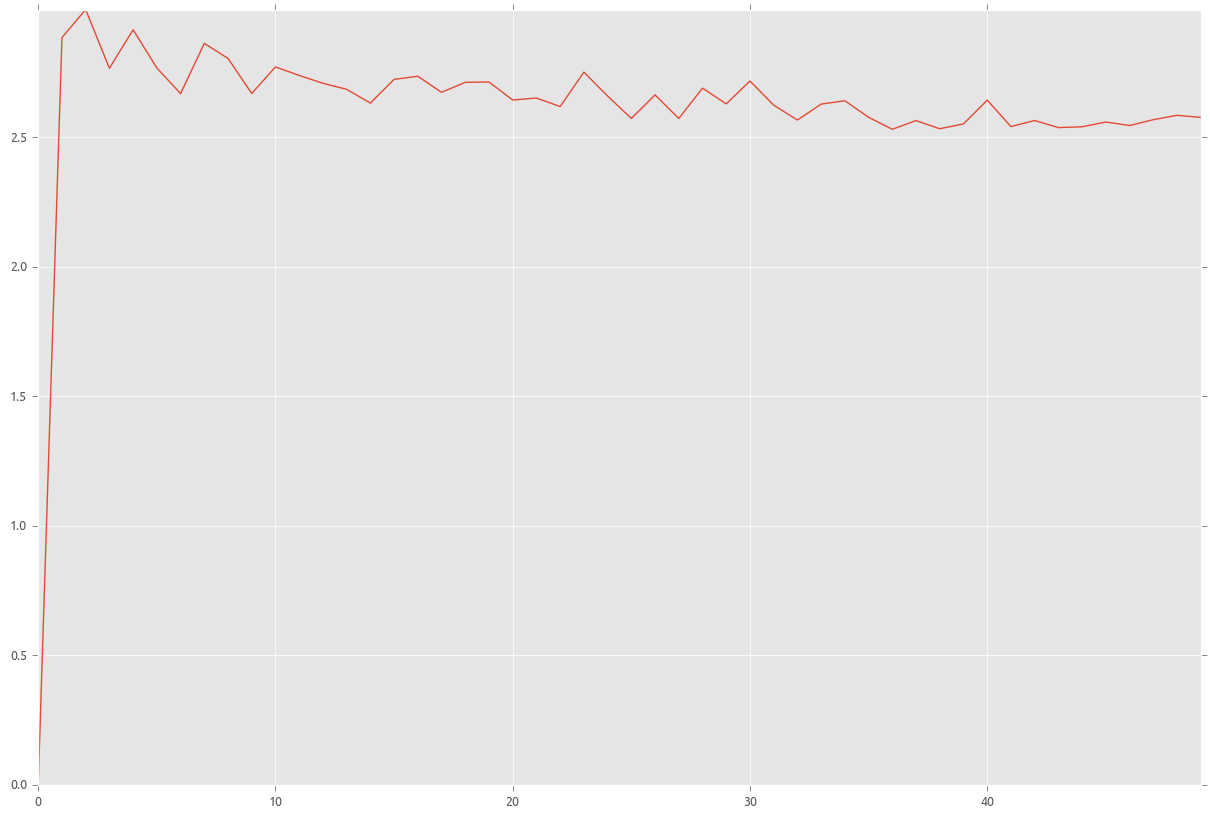

In [68]:
optimize(training_epochs, train_features, train_one_hot)

In [62]:
def make_prediction(test_f, test_l, test_ID):
    ID_list = np.unique(test_ID)
    y_pred = []
    y_true = []
    for sound_ID in ID_list:
        indices = np.where(test_ID == sound_ID)
        input_x = np.float32(test_f[indices])
        true_y = test_l[indices][0]
        feed_dict_test = {X: input_x, keep_prob: 0.5}
        pred_y = session.run(y_,feed_dict=feed_dict_test)
        pred_y = np.amax(pred_y, axis=0)
        pred_y = np.argmax(pred_y)
        true_y = np.argmax(true_y)
        y_pred.append(pred_y)
        y_true.append(true_y)
    return np.array(y_pred), np.array(y_true)
    
    
    

In [69]:
y_pred, y_true = make_prediction(test_features, one_hot_encode(test_labels), test_IDs) 

In [70]:
 p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    
print "F-Score:", round(f,3)
print "Confusion Matrix: "
print confusion_matrix(y_true, y_pred)

F-Score: 0.129
Confusion Matrix: 
[[75  0 64  5 15 26  0 30 30 54]
 [18  0 16  1  3  5  0  4  7 10]
 [72  0 74  1 16 30  0 33 31 36]
 [48  0 61  1 15 17  0 16 20 31]
 [59  0 56  3 13 21  0 27 24 48]
 [63  0 62  6 22 31  0 26 39 40]
 [ 1  0  4  0  3  0  0  1  0  3]
 [50  0 67  1 24 26  0 23 24 35]
 [63  0 77  5 20 20  0 31 25 33]
 [83  0 72  6 21 22  0 25 25 46]]
